In [30]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)


2.2.1
2.2.1
cpu


In [31]:
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

SPEECH_FILE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
# SPEECH_FILE = 'my_audio.wav'

Creating a pipeline

In [32]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())


Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [33]:
model = bundle.get_model().to(device)

print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


Loading data

In [34]:
IPython.display.Audio(SPEECH_FILE)

In [43]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

print(waveform.shape)
print(sample_rate)

torch.Size([1, 54400])
16000


Extracting acoustic features


In [49]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)
print(features)
# how many layers/features we have, transformer encoder has 12 layers
print(len(features))
# take the last layer
feature = features[-1]
print(feature.shape)
# total stride for W2V model is 320, 54400/320=~170, each frame is represented by a 768 dimensional vector

[tensor([[[ 0.1649,  0.2176,  0.0993,  ...,  0.3318,  0.0641,  0.0393],
         [ 0.1101,  0.0955,  0.0116,  ...,  0.4119, -0.0303,  0.0518],
         [-0.0709,  0.1380, -0.0045,  ...,  0.5973, -0.0263,  0.1750],
         ...,
         [-0.1441, -0.1851, -0.0425,  ...,  0.4558,  0.1976,  0.1106],
         [ 0.0929,  0.0386,  0.2404,  ...,  0.0550, -0.1844, -0.2647],
         [ 0.4033,  0.0617, -0.0814,  ..., -0.0870, -0.0457, -0.1930]]]), tensor([[[ 0.2421, -0.1542,  0.0445,  ...,  0.2425,  0.0663,  0.0524],
         [ 0.2178, -0.1804, -0.1847,  ...,  0.4040,  0.0467,  0.0768],
         [ 0.1052, -0.1536, -0.3267,  ...,  0.6410,  0.0248,  0.1306],
         ...,
         [ 0.3346, -0.2729, -0.0633,  ...,  0.6496, -0.0886, -0.0363],
         [ 0.3577, -0.3867, -0.0862,  ...,  0.2462,  0.0859, -0.0335],
         [ 0.2619, -0.0295, -0.0057,  ..., -0.1740, -0.1245, -0.1171]]]), tensor([[[ 0.2829, -0.3029,  0.1391,  ...,  0.0682, -0.1187,  0.1308],
         [ 0.2352, -0.1811,  0.0590,  ...,

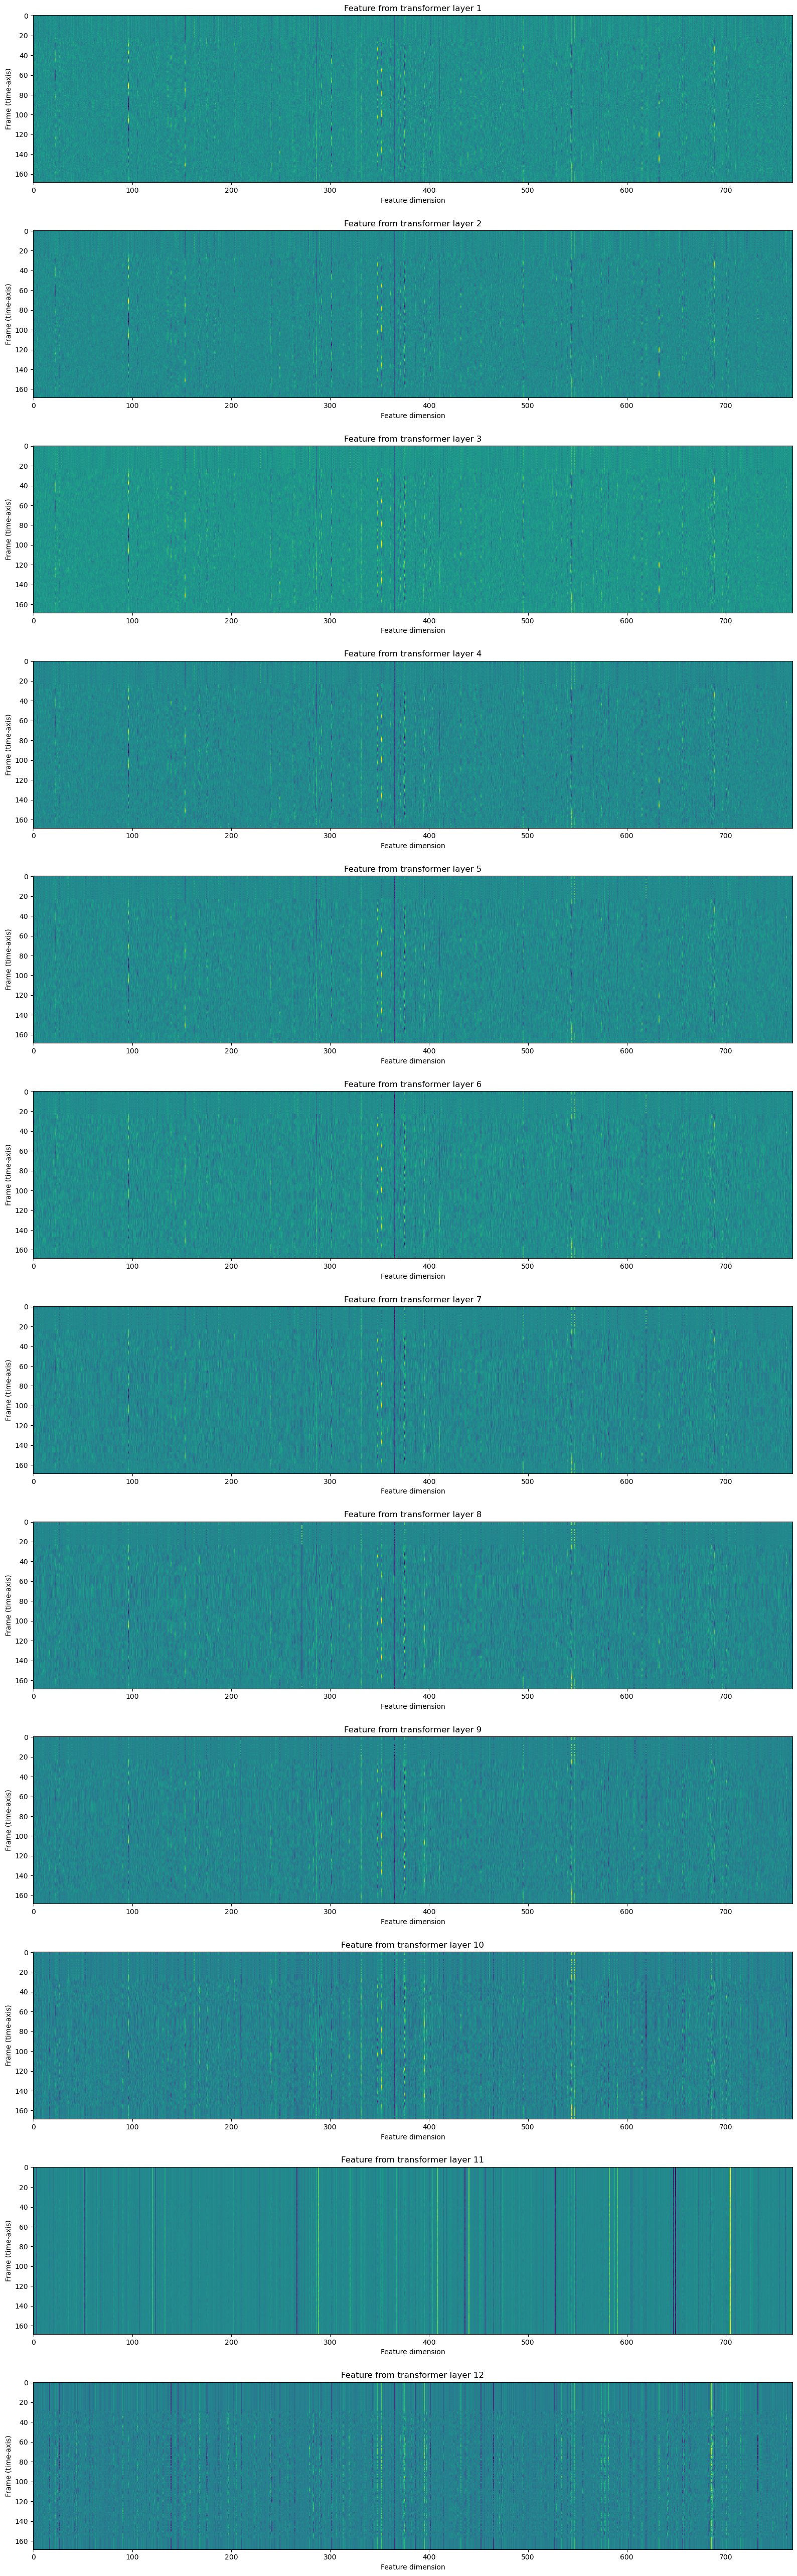

In [37]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
fig.tight_layout()

Feature classification


In [55]:
with torch.inference_mode():
    emission, _ = model(waveform)
print(emission.shape)
print(emission)

torch.Size([1, 169, 29])
tensor([[[15.2334, -1.8708, -3.2883,  ..., -6.7972, -6.9657, -7.4782],
         [15.2037, -1.9888, -3.3543,  ..., -6.7461, -6.8553, -7.5178],
         [15.2477, -2.0613, -3.2648,  ..., -6.7417, -6.8254, -7.5299],
         ...,
         [14.9048, -2.5300, -4.2224,  ..., -5.6419, -6.3303, -7.5235],
         [15.1740, -1.5061, -3.0892,  ..., -7.0472, -7.5668, -7.5629],
         [15.1210, -0.2932, -2.9572,  ..., -7.3561, -7.9187, -7.5750]]])


Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


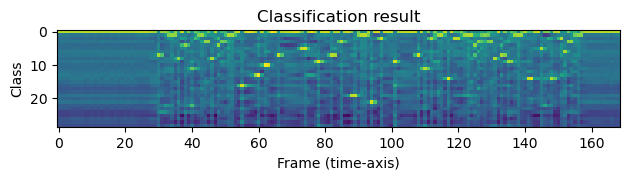

In [39]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.tight_layout()
print("Class labels:", bundle.get_labels())

Text(0.5, 1.0, 'Softmaxed Emissions')

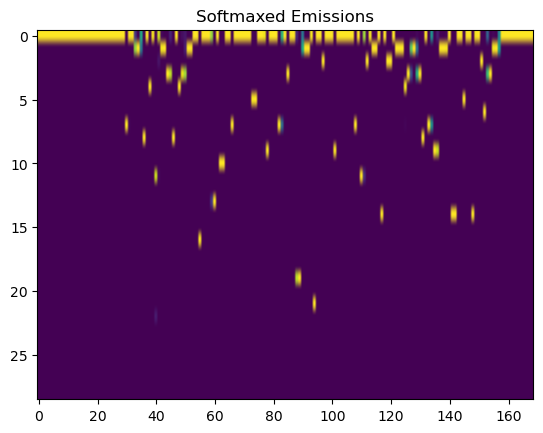

In [59]:
# check softmax probabilities
import torch.nn.functional as F
probs = F.softmax(emission[0], dim=-1)
plt.imshow(probs.T.cpu(), aspect='auto')
plt.title("Softmaxed Emissions")


Generating transcripts

In [40]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [41]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [42]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|


In [ ]:
model = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H.get_model()
emission = model(waveforms, ...)
